# AAI3001 Final Project - Preliminary Research Notebook
### Group 8
- Chua Chen Yi
- Wong Jun Kai
- Leena Soo Wei Qi
- Heng Yu Xin

#### In this notebook, we conduct a brief sanity check of our progress, primarily to confirm that:
1. Our dataset has been properly formatted.
2. We are able to apply transfer learning to a pre-trained YOLO model.
3. The initial model performance is satisfactory.

## Dataset Details

#### Initial Dataset (350 Images)
Our initial dataset consists of 350 Images. These are recorded from the 3D printer's built in webcam. We obtain our images as snapshots from a mix of timelapse and regular videos. These have been roughly split into 65:25:10 (train/val/test), of these, 157 have at least one failure in them, and the remaining are background images.

- #### Timelapse Videos
These captures movement across the entire print cycle, and are representative of an entire print, which takes more than an hour on averages. Frames are captured at the start of each layer, where each layer is 0.2mm in height. Therefore an object of 1cm will have 5 frames captures. However, a shortfall of this method is key moments, such as the start of a print failure occuring might get missed if they do not occur at the start of the new layer.
- #### Regular Videos
These captures movement across a specific moment in the print cycle. We record the entire footage and pick out key moments. We use this to capture the initial moments where the print failure occurs. As this is a regular 30FPS video, we are able to capture more frames and populate our dataset with these key moments. As 30FPS will generate too many similar images, we record them in a 15:1 ratio (We capture one frame for every 15 frame of video). This is till much faster than timelapse, which might only capture a single image every 2+ mins.

Unfortunately, we were unable to organically capture an actual failure. Hence we have to simulate one. In particular, we will focus on ["spaghetti"](https://help.prusa3d.com/article/spaghetti-monster_1999) failures, which are the most common form of failure that has no recovery. I.e. encountering one will result in the print having to be completely discarded and restarted.

The failures from this initial dataset is simulated by printing a very thin but tall object. When it inevitably falls over, filament will get dragged everywhere.

#### Updated Dataset (630 Images)
Based on the initial testing, we have updated the dataset with 280 more images. These are obtained similarly to the initial dataset, but using seperate camera for another slightly different perspective. These additional images are split into (80:10:10) where 145 of 280 images have at least one failure in them. The failures simulated are also done using two different methods:

We designed [two files](https://cad.onshape.com/documents/f5fa610d41301785390c590c/w/85f44a550e1a6889dc6a74d6/e/ebb2803dda6e79d8e5a7e7c0?renderMode=0&uiState=6743750fd0d06252d2c72f97) that when printed will result in failure:

- File-1: Unsupported cantiliver. This simulates a spagehetti failure mid-print. This can occur of the print belts skip, or due to a bad design which causes the printer to print "mid-air".

- File-2: Lack of adhesion. This simulates when the print surface is dirty, and the first layer does not stick to it, similar to the initial dataset. The filament will be dragged around a large area.



## Dataset Annotation
We use [makesense](https://makesense.ai) to annotate our dataset, which also conveniently formats in YOLO. As we are only interesting in single class; failure, we only use a single label.

# Preview dataset images

In [1]:
# Dataset root folder
dataset_path = r"C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_updated"

# Images
train_folder = dataset_path + r"\images\train"
test_folder = dataset_path + r"\images\test"
val_folder = dataset_path + r"\images\val"

# Labels
train_label_folder = dataset_path + r"\labels\train"
test_label_folder = dataset_path + r"\labels\test"
val_label_folder = dataset_path + r"\labels\val"

In [2]:
# Import Stuff
import os
import random
import cv2
from matplotlib import pyplot as plt

**NOTE! If random.sample returns a background image, no boxes will be drawn!**

In [3]:
# Helper function to preview bounding box. 
def draw_bounding_boxes(image, label_file):
    h, w, _ = image.shape  # Get the image dimensions

    # Read the label file
    with open(label_file, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # Parse the YOLO label format
        parts = line.strip().split()
        class_id, center_x, center_y, bbox_width, bbox_height = map(float, parts)

        # Convert normalized coordinates to pixel values
        x1 = int((center_x - bbox_width / 2) * w)
        y1 = int((center_y - bbox_height / 2) * h)
        x2 = int((center_x + bbox_width / 2) * w)
        y2 = int((center_y + bbox_height / 2) * h)

        # Draw the bounding box (red color, thicker border)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), thickness=6)
        cv2.putText(image, str(int(class_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return image

C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_updated\labels\train\FC29.txt
C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_updated\labels\train\FA10.txt
C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_updated\labels\train\BA041.txt


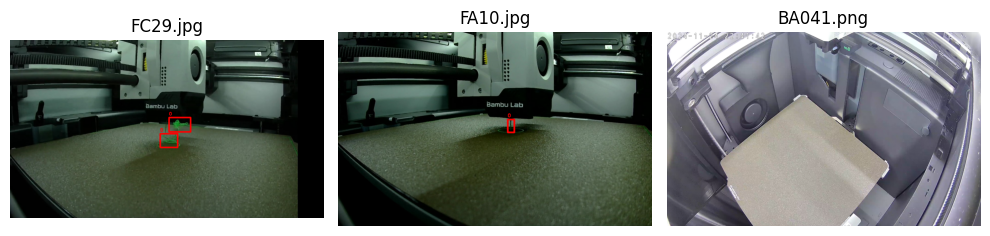

In [4]:
# Get a list of all image files in the folder
image_files = [f for f in os.listdir(train_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check if there are enough images in the folder
if len(image_files) < 3:
    print(f"Err: Check folder paths")
    
else:
    # Select 3 random images
    selected_images = random.sample(image_files, 3)

    # Display the selected images with bounding boxes
    plt.figure(figsize=(10, 5))

    for i, img_file in enumerate(selected_images):
        # Read the image using OpenCV
        img_path = os.path.join(train_folder, img_file)
        img = cv2.imread(img_path)

        # Find the corresponding label file
        label_file = os.path.join(train_label_folder, os.path.splitext(img_file)[0] + '.txt')
        print(label_file)

        # If a label file exists, draw the bounding boxes
        if os.path.exists(label_file):
            img = draw_bounding_boxes(img, label_file)

        # Convert BGR to RGB for displaying with Matplotlib
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(img_file)
        plt.axis('off')

    # Show the images
    plt.tight_layout()
    plt.show()

# Sanity Check - Train Model
#### Use transfer learning on a pre-trained YOLOv11 model, then evaluate

In [5]:
# Import stuff
from ultralytics import YOLO

In [6]:
# Create a new YOLO model from scratch
model = YOLO("yolo11n.yaml")

# Load a pretrained YOLO model
model = YOLO("yolo11n.pt")

In [7]:
# Train the model using the 'coco8.yaml' dataset for 3 epochs
results = model.train(data="datasets/3dprint_updated.yaml", epochs=30)

New https://pypi.org/project/ultralytics/8.3.37 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=datasets/3dprint_updated.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_updated\labels\train... 204 ima

train: New cache created: C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_updated\labels\train.cache



val: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_updated\labels\val... 42 images, 

val: New cache created: C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_updated\labels\val.cache


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.36G      2.551      5.118      1.792          8        640: 100%|██████████| 28/28 [00:05<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61    0.00103       0.59     0.0908     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.39G      2.275      3.769      1.726         12        640: 100%|██████████| 28/28 [00:03<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61   0.000855      0.492    0.00146   0.000411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.38G      2.259      3.485      1.843         12        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.246     0.0656      0.104     0.0304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.38G      2.187      2.949      1.748         18        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.185      0.357       0.11     0.0332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.38G      2.211       2.75       1.75          8        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.364      0.311       0.23     0.0745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.4G      2.223      2.532      1.757          8        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.364      0.131      0.146     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.38G       2.24        2.3      1.767         24        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.354      0.475        0.3     0.0895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.39G      2.203      2.244      1.726          8        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.469      0.541      0.487      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.38G      2.066      1.986      1.646          4        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.708      0.443      0.529      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.39G      2.054      1.873      1.602         12        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.506      0.605      0.551      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       2.4G      2.028      1.758      1.578         11        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61       0.51      0.541      0.523      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.39G       1.99      1.654      1.585         13        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.513      0.443      0.414      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.38G       1.94      1.612      1.611          8        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61       0.66       0.59      0.655       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.38G      1.986      1.566      1.623         18        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.708      0.475      0.587      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.38G      2.057      1.533      1.623         14        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.584      0.621      0.614       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.38G      1.925      1.376      1.558         11        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.772      0.623      0.695      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.38G      1.891      1.411      1.532         10        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61       0.68      0.626      0.694      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.38G      1.884      1.352      1.523          5        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.789      0.552      0.669      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.38G      1.825      1.309      1.484         12        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.618      0.717       0.69      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.38G      1.849      1.288      1.515         11        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.762      0.631      0.746       0.25


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.49G       1.91      1.471       1.62          7        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61       0.65      0.638      0.679      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.38G      1.784      1.332      1.517          8        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.793      0.689      0.761      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.38G      1.714      1.276      1.505          5        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.734      0.723      0.783      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.38G      1.768      1.207       1.53         12        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.718      0.689      0.732      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.38G      1.687      1.169      1.491          5        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.743      0.689       0.75      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.38G       1.64      1.121      1.466          5        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.735      0.729      0.771      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.38G      1.665       1.11      1.469          6        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.781      0.689      0.761      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.38G       1.66      1.096      1.454         10        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.794      0.787      0.795       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.38G      1.604      1.073      1.439          5        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61       0.85      0.738      0.796      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.38G      1.614      1.079      1.438          8        640: 100%|██████████| 28/28 [00:03<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        117         61      0.818      0.735      0.783      0.297



30 epochs completed in 0.040 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 5.5MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0


                   all        117         61      0.794      0.787      0.795      0.311
Speed: 0.2ms preprocess, 0.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\train3


In [8]:
# Evaluate the model's performance on the validation set
results = model.val()

Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_updated\labels\val.cache... 42 im
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<0


                   all        117         61      0.806      0.787      0.786      0.318
Speed: 0.3ms preprocess, 4.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train32


# View Results

In [9]:
# Load the generated images
image1 = r"./runs/detect/train32/val_batch0_labels.jpg"
image2 = r"./runs/detect/train32/val_batch0_pred.jpg"
image3 = r"./runs/detect/train32/val_batch1_labels.jpg"
image4 = r"./runs/detect/train32/val_batch1_pred.jpg"

------------------ [LABEL] ./runs/detect/train32/val_batch0_labels.jpg ------------------


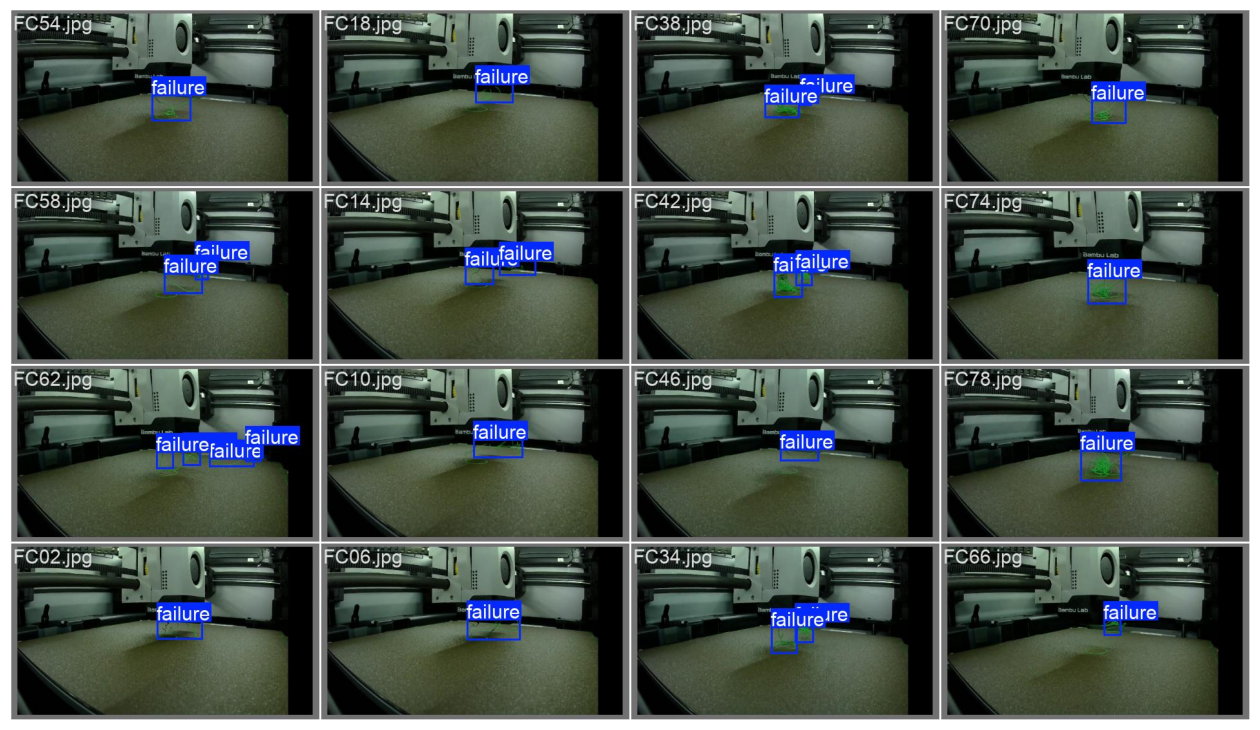



------------------ [PREDICTION] ./runs/detect/train32/val_batch0_pred.jpg ------------------


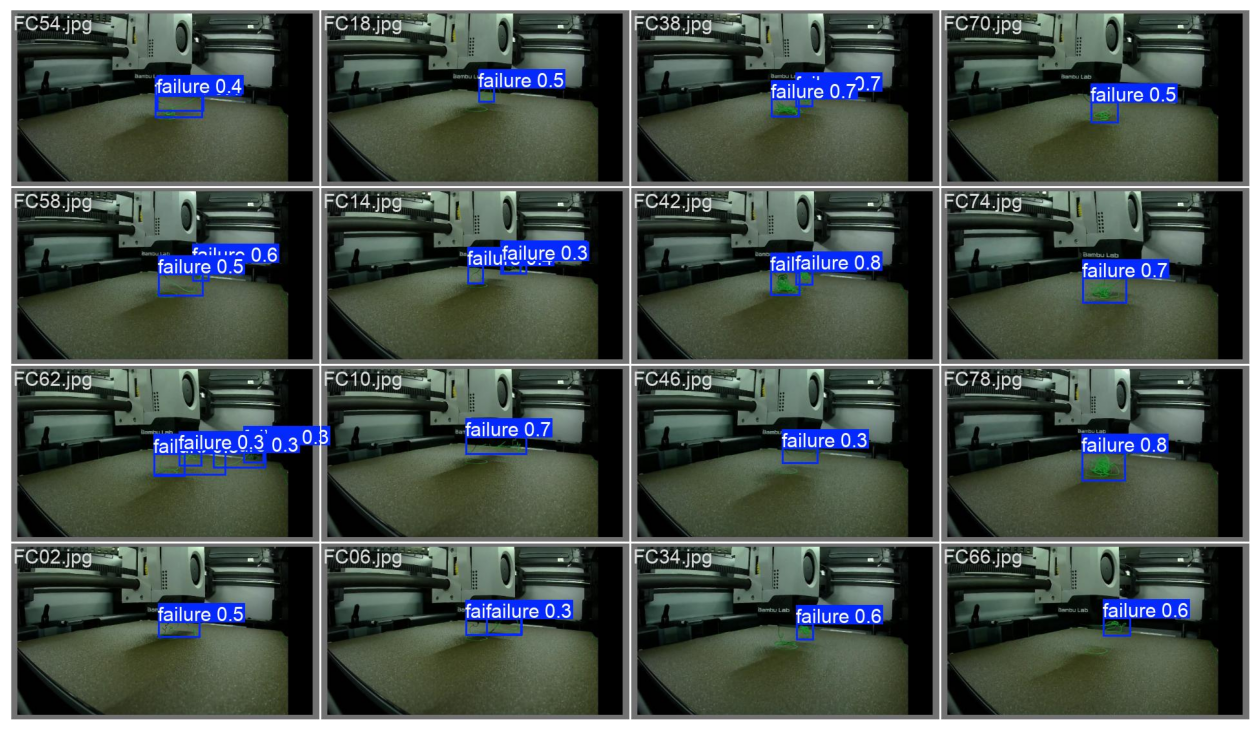



------------------ [LABEL] ./runs/detect/train32/val_batch1_labels.jpg ------------------


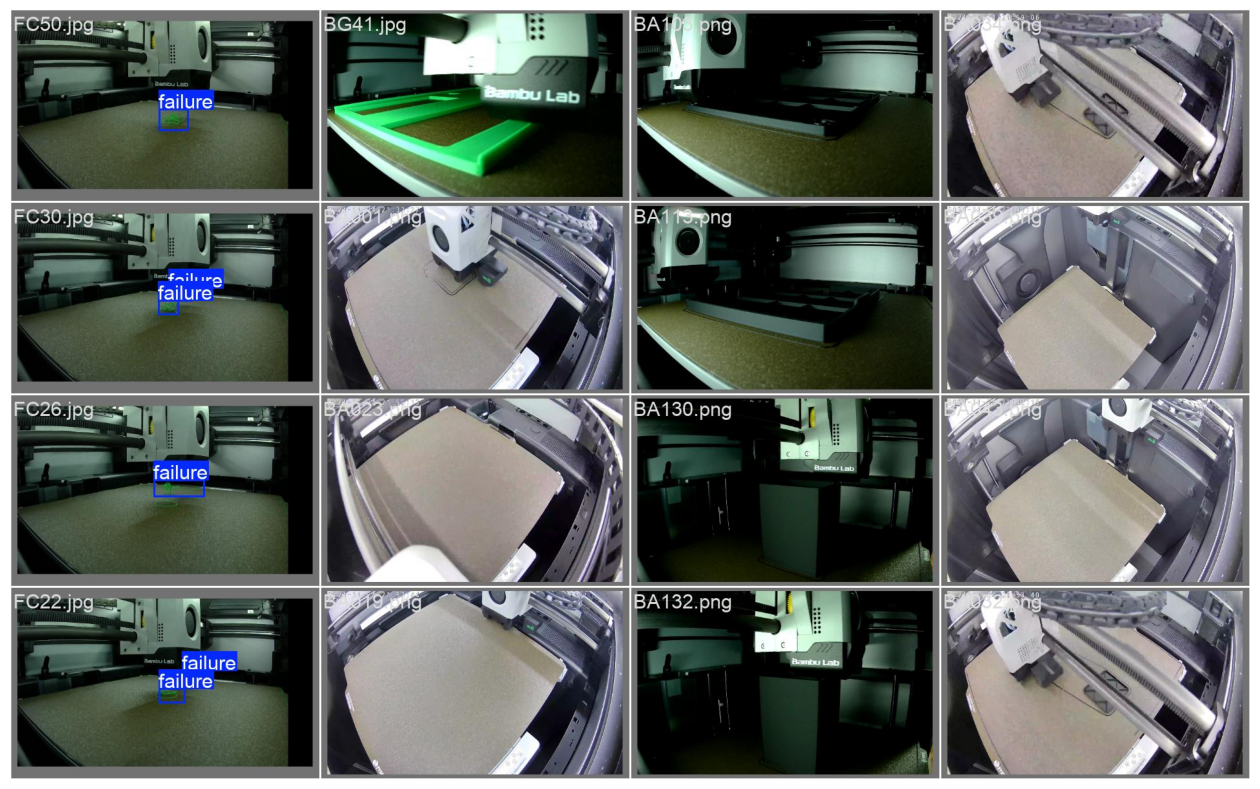



------------------ [PREDICTION] ./runs/detect/train32/val_batch1_pred.jpg ------------------


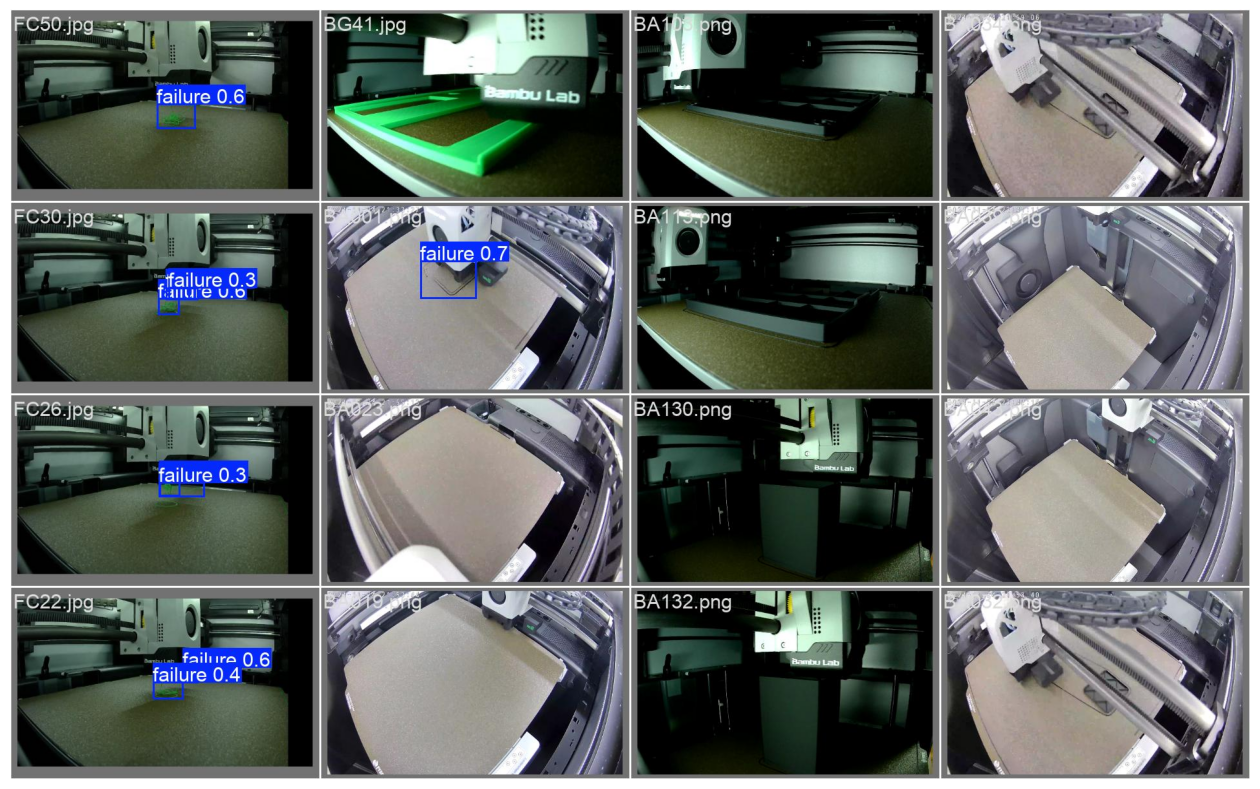

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
count = 1
for path in [image1, image2, image3, image4]:
        
    if ((count % 2) == 0):
        print(f"------------------ [PREDICTION] {path} ------------------")
    else:
        print(f"------------------ [LABEL] {path} ------------------")
    count += 1;
    
    img = mpimg.imread(path)
    plt.figure(figsize=(16, 16))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
    print("\n")

# Evaluation
#### *On initial dataset of 350 images!*
- Overall it performed unexpectedly well based on the generated images. Except for FC46.jpg where it was unable to detect the very small loose filament oozing from the nozzle.
- It was able to correctly identify at least one failure from each of the images with failures. 
- Crucially, none of the background images have any false positives. This is important, as it means it has a low false positive rate, or high precision. In most AI fault detection systems, a false positive will cause the print to stop until a human gives it the clearance to proceed if it was a false positive, wasting time.**